# Wastyk et al. (2021) from the Sonnenburg Lab showed in a feeding study the inter-individual differences in inflammatory immune response after intervention with a high-fiber diet. Here, we use microbial sequencing data from this study to compare the results of MICOM metabolic modeling with the results obtained by the authors. Specifically, we are curious whether the SCFA production profiles from our metabolic models agree with the inflammatory immune response group used by the authors to categorize study participants

In [1]:
import os
import pandas as pd
from plotnine import *
from tqdm import tqdm
import numpy as np
import scipy
import micom
import micom.measures

%matplotlib inline

## Load up the taxonomic abundances and build a taxonomy table for use in MICOM. We have a separate file with taxon names for each ASV that we will load as a dict and map onto the taxonomy table

In [72]:
# Load abundance data
taxonomy = pd.read_csv('../data/fiberstudy_abundances.csv')
# Load ASV file as a dict
asv = pd.read_csv('../data/fiberstudy_ASVs.csv', index_col = 0)['0'].to_dict()
# Rename abundance data columns with ASV names
taxonomy = taxonomy.rename(columns = asv)
# Create a unique sample ID for each participant at each timepoint
taxonomy['sample_id'] = taxonomy['participant'].astype('str')+'_'+taxonomy['timepoint'].astype('str')
# Table include samples that underwent a different intervention - filter to only fiber intervention
taxonomy = taxonomy[taxonomy['group']=='Fiber']
# Timepoints 8 and 9 are in the 'participant choice' part of the intervention - we'll exclude these
taxonomy = taxonomy[~(taxonomy['timepoint']==8)&~(taxonomy['timepoint']==9)]
# Group duplicated columns
taxonomy = taxonomy.groupby(axis=1, level=0).sum()
# Save the metadata for future use
metadata = taxonomy.set_index('sample_id')[['participant','timepoint','immune_group']]
# Melt into a longform dataframe
taxonomy = pd.melt(taxonomy,
                   id_vars = ['sample_id','participant','group','timepoint','immune_group'],
                   value_vars = taxonomy.columns[4:-1], 
                   var_name = 'id',
                   value_name = 'abundance')
# Add a genus column, as required by MItCOM for the taxonomy table
taxonomy['genus'] = taxonomy['id'].str.split(';').str[5].str.split('.').str[0]
# Drop columns where genus is undefined
taxonomy['genus'].replace('',np.nan, inplace = True)
taxonomy.dropna(how = 'any', inplace = True)
taxonomy

,sample_id,participant,group,timepoint,immune_group,id,abundance,genus
0,8001_1,8001,Fiber,1,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
1,8001_2,8001,Fiber,2,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000211,Actinomyces
2,8001_3,8001,Fiber,3,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
3,8001_4,8001,Fiber,4,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
4,8001_5,8001,Fiber,5,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
...,...,...,...,...,...,...,...,...
14989,8041_3,8041,Fiber,3,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.000000,Akkermansia
14990,8041_4,8041,Fiber,4,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.002774,Akkermansia
14991,8041_5,8041,Fiber,5,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.000000,Akkermansia
14992,8041_6,8041,Fiber,6,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.000000,Akkermansia


## Before building our models we need to define our model database

In [73]:
agora = ('../agora/data')

## Now we'll build the models using our abundance table. 

In [74]:
models = micom.workflows.build(taxonomy,out_folder = '../models/fiber_study',
                 model_db = agora, cutoff = 0.001, threads = 10)

Output()

## Load up the high-fiber medium we'll use to grow the models, which has been completed via the medium_construction.ipynb notebook

In [281]:
medium = pd.read_csv('../media/highfiber.csv')

## Next, grow the samples with the high fiber medium and a tradeoff value of 0.7

In [269]:
# Read the model manifest
manifest = pd.read_csv('../models/fiber_study/manifest.csv')
# Grow the models with a tradeoff value of 0.7
growth = micom.workflows.grow(manifest,'../models/fiber_study',medium=medium,tradeoff=.7,strategy='none',threads = 20)
# # Collect the absolute production rates
production = micom.measures.production_rates(growth)

Output()

/users/nbohmann/.local/lib/python3.8/site-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [270]:
# Isolate SCFA production
scfa = production[(production['metabolite']=='but[e]')|(production['metabolite']=='ppa[e]')|(production['metabolite']=='ac[e]')]
# Pivot the results for plotting
scfa = pd.pivot(scfa,
                index = 'sample_id',
                columns = 'metabolite',
                values = 'flux')
# Map the immune group and timepoint from the metadata
scfa['immune_group'] = scfa.index.map(metadata['immune_group'].to_dict())
scfa['timepoint'] = scfa.index.map(metadata['timepoint'].to_dict())
# Add butyrate and propionate together |
scfa['but_ppa'] = scfa['ppa[e]']+scfa['but[e]']

## Now, plot the predicted production among each inflammation group, at each timepoint across the intervention and average. We'll do acetate first, then propionate plus butyrate (both anti inflammatory)

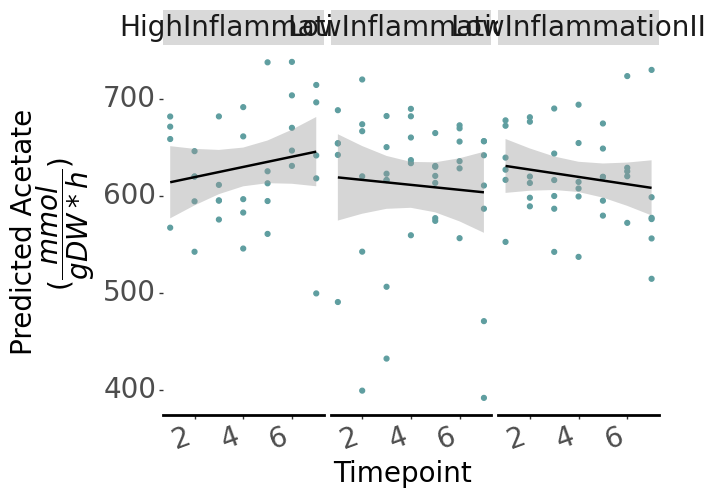

<ggplot: (8762715472246)>

In [282]:
plt1 = (ggplot(scfa,
    aes(x = 'timepoint', y = 'ac[e]'))
    +geom_point(color = 'cadetblue')
    +geom_smooth(method = 'lm')
    +labs(x = 'Timepoint', y = 'Predicted Acetate \n ($\dfrac{mmol}{gDW*h}$)')
    +facet_wrap(facets = 'immune_group')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                axis_line_y = element_blank(), axis_text_x=element_text(rotation = 20, hjust = 1)))
plt1

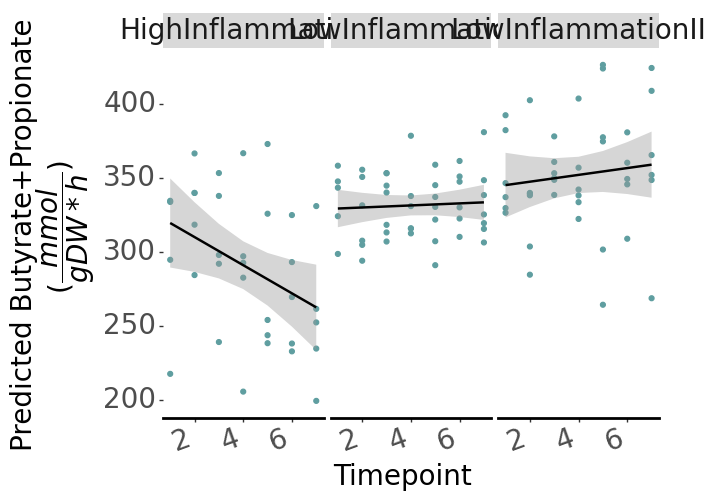

<ggplot: (8762406625440)>

In [283]:
plt2 = (ggplot(scfa,
    aes(x = 'timepoint', y = 'but_ppa'))
    +geom_point(color = 'cadetblue')
    +geom_smooth(method = 'lm')
    +labs(x = 'Timepoint', y = 'Predicted Butyrate+Propionate \n ($\dfrac{mmol}{gDW*h}$)')
    +facet_wrap(facets = 'immune_group')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                axis_line_y = element_blank(), axis_text_x=element_text(rotation = 20, hjust = 1)))
plt2

## Let's also look at average production across the entire intervention per immune group. Again, we'll start with acetate, then do propionate plus butyrate

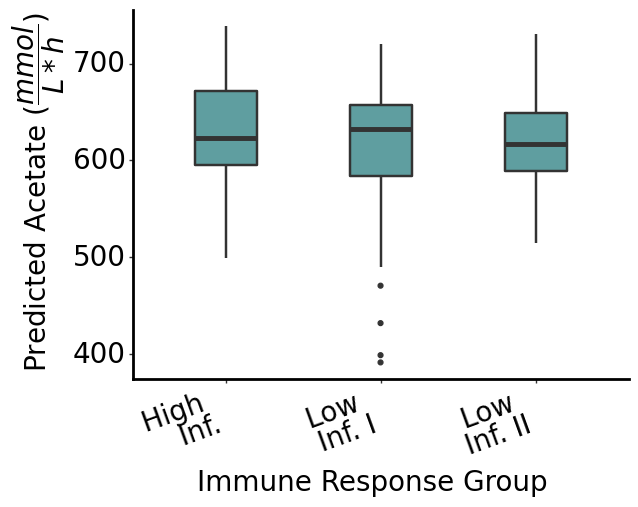

<ggplot: (8762414337461)>

In [275]:
plt3 = (ggplot(scfa, 
        aes(x = 'immune_group', y = 'ac[e]'))
        +geom_boxplot(fill = 'cadetblue',size = 1, width = 0.4)
        +labs(x = 'Immune Response Group', y = 'Predicted Acetate ($\dfrac{mmol}{L*h}$)')
        +scale_x_discrete(limits = ['HighInflammation','LowInflammationI','LowInflammationII'],
                          labels = ['High \n Inf.', 'Low \n Inf. I', 'Low \n Inf. II'])
        +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1)))
plt3

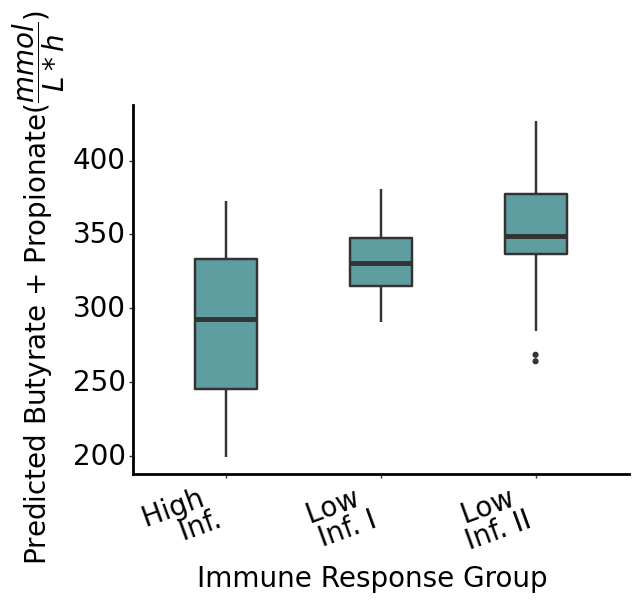

<ggplot: (8762413969764)>

In [276]:
plt4 = (ggplot(scfa,
        aes(x = 'immune_group', y = 'but_ppa'))
        +geom_boxplot(fill = 'cadetblue',size = 1, width = 0.4)
        +labs(x = 'Immune Response Group', y = 'Predicted Butyrate + Propionate($\dfrac{mmol}{L*h}$)')
        +scale_x_discrete(limits = ['HighInflammation','LowInflammationI','LowInflammationII'],
                          labels = ['High \n Inf.', 'Low \n Inf. I', 'Low \n Inf. II'])
        +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1)))
plt4